# Subset Rectangles

Create rectangular covering for coastline buffer. To be used for subsetting Sentinel-2 images, for indexing areas by grid tiles for training/validation/testing.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import geopandas as gpd
import contextily as cx

In [4]:
import mgrs

In [5]:
from shapely.geometry import MultiPolygon, Polygon, Point, box

In [6]:
from shapely.ops import unary_union

In [7]:
import shapely.wkt

In [12]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

## Coastline buffer

In [13]:
tileId = '30UUA'

In [14]:
wkt_fp = os.path.join(DATA_DIR, f'coastline_buffer/Buffered_Coastline_{tileId}.wkt')

In [15]:
with open(wkt_fp, 'r') as f:
    wkt = f.read()

In [16]:
poly = gpd.GeoSeries.from_wkt([wkt])

## Rectangle covering - MGRS method

In [17]:
def latlon_to_mgrs_tile(lat, lon, precision=1):
    try:
        m = mgrs.MGRS()
        mgrs_code = m.toMGRS(lat, lon, MGRSPrecision=precision)
        tile = mgrs_code
        return tile
    except Exception as e:
        print(f'Error computing MGRS for point {lat}, {lon}')
        raise

In [62]:
p = Point(m.toLatLon('30UUA53'))

In [63]:
poly.contains(p)

0    False
dtype: bool

In [80]:
for i in range(9):
    for j in range(9):
        lat_min, lon_min = m.toLatLon(f'30UUA{i}{j}')
        lat_max, lon_max = m.toLatLon(f'30UUA{i+1}{j+1}')
        pBox = box(lat_min, lon_min, lat_max, lon_max)
        if poly.intersects(pBox)[0]:
            print(f"{i}, {j}")

In [113]:
m = mgrs.MGRS()

def get_mgrs_tiles_covering_polygon(polygon, mgrs_tile="30UUA"):
    """
    Find all 10km x 10km MGRS tiles within a given MGRS 100km grid square (e.g., 30UUA)
    that intersect the polygon.

    :param polygon: Shapely polygon (buffered coastline)
    :param mgrs_tile: 100km MGRS tile ID (e.g., "30UUA")
    :return: List of MGRS precision 1 tiles that intersect the polygon
    """
    intersecting_tiles = []
    boxes = []

    for i in range(10):  # 10x10 subtiles (10km resolution)
        for j in range(10):
            # Create full MGRS code for the center of this 10km x 10km tile
            full_mgrs_code = f"{mgrs_tile}{i}{j}"  # Center coordinate (5,5)
            
            try:
                lat, lon = m.toLatLon(full_mgrs_code)
                
                # Approximate MGRS 10km tile bounds
                tile_size = 0.15  # Roughly 10km in lat/lon degrees
                lat_min = lat
                lat_max = lat + tile_size
                lon_min = lon
                lon_max = lon + tile_size

                # Create bounding box
                pBox = box(lon_min, lat_min, lon_max, lat_max)

                # Check for intersection
                if polygon.intersects(pBox)[0]:
                    intersecting_tiles.append(f"{mgrs_tile}{i}{j}")
                    boxes.append(pBox)
            
            except Exception as e:
                print(f"Error processing {full_mgrs_code}: {e}")

    return intersecting_tiles, boxes

# Example usage:
# polygon_wkt = "POLYGON((-4 50, -3.5 50, -3.5 50.5, -4 50.5, -4 50))"
# polygon = gpd.GeoSeries.from_wkt([polygon_wkt])[0]

tiles, boxes = get_mgrs_tiles_covering_polygon(poly, mgrs_tile="30UUA")
print("Intersecting MGRS Precision 1 Tiles:", tiles)


Intersecting MGRS Precision 1 Tiles: ['30UUA03', '30UUA04', '30UUA05', '30UUA06', '30UUA13', '30UUA14', '30UUA15', '30UUA16', '30UUA24', '30UUA25', '30UUA26', '30UUA27', '30UUA32', '30UUA33', '30UUA34', '30UUA35', '30UUA36', '30UUA37', '30UUA38', '30UUA42', '30UUA43', '30UUA44', '30UUA45', '30UUA46', '30UUA47', '30UUA48', '30UUA49', '30UUA53', '30UUA54', '30UUA55', '30UUA56', '30UUA57', '30UUA58', '30UUA59', '30UUA64', '30UUA65', '30UUA66', '30UUA67', '30UUA68', '30UUA69', '30UUA75', '30UUA76', '30UUA77', '30UUA78', '30UUA79', '30UUA86', '30UUA87', '30UUA88', '30UUA96', '30UUA97', '30UUA98']


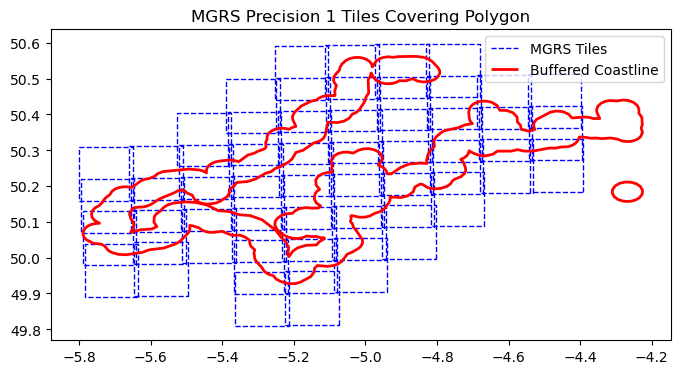

In [133]:
# Convert to GeoDataFrame
gdf_tiles = gpd.GeoDataFrame(geometry=boxes)
gdf_polygon = gpd.GeoDataFrame(geometry=[geom])

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_tiles.boundary.plot(ax=ax, color="blue", linewidth=1, linestyle="--", label="MGRS Tiles")
gdf_polygon.boundary.plot(ax=ax, color="red", linewidth=2, label="Buffered Coastline")

# Labels & Legend
ax.set_title("MGRS Precision 1 Tiles Covering Polygon")
ax.legend()
plt.savefig(os.path.join(FIGURES_DIR, 'mgrs_covering'))
plt.show()

In [116]:
cover_union = unary_union(boxes)

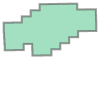

In [117]:
cover_union

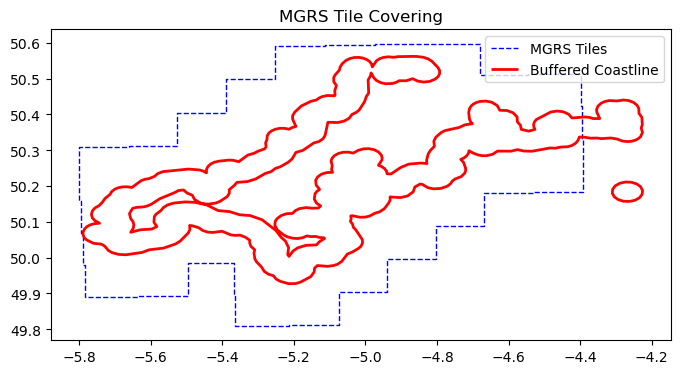

In [134]:
# Convert to GeoDataFrame
gdf_cover = gpd.GeoDataFrame(geometry=[cover_union])

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_cover.boundary.plot(ax=ax, color="blue", linewidth=1, linestyle="--", label="MGRS Tiles")
gdf_polygon.boundary.plot(ax=ax, color="red", linewidth=2, label="Buffered Coastline")

# Labels & Legend
ax.set_title("MGRS Tile Covering")
ax.legend()
plt.savefig(os.path.join(FIGURES_DIR, 'mgrs_covering_union'))
plt.show()

## Land polygons

In [24]:
land_fp = os.path.join(DATA_DIR, 'simplified-land-polygons-complete-3857/simplified_land_polygons.shp')
land_polys = gpd.read_file(land_fp)

In [28]:
land_polys = land_polys.to_crs("EPSG:32630")

## Rectangle covering - metric coordinates method

In [19]:
import math

In [20]:
def min_max_round(array, step_size):
    res = np.zeros(4)
    res[0] = int(math.floor(array[0] / step_size)) * step_size
    res[1] = int(math.floor(array[1] / step_size)) * step_size
    res[2] = int(math.ceil(array[2] / step_size)) * step_size
    res[3] = int(math.ceil(array[3] / step_size)) * step_size
    return res

In [29]:
# Sentinel-2 Sub-tile Size in EPSG:32630
STEP_SIZE = 10000  # 10.0 km in meters

def create_epsg_grid(polygon, land_df, crs="EPSG:32630"):
    """
    Generate a regular grid covering for a polygon in a given CRS.
    
    :param polygon: Shapely Polygon (buffered coastline)
    :param land_df: Land DataFrame
    :param crs: Target coordinate reference system (default: EPSG:32630)
    :return: List of intersecting tile bounding boxes
    """
    # Reproject polygon to EPSG:32630
    geometry = polygon.geometry.iloc[0]
    if isinstance(geometry, MultiPolygon):
        polygons = list(geometry.geoms)
    else:
        polygons = geometry
    
    gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326").to_crs(crs)
    polygons_utm = list(gdf_polygons.geometry)

    # Get bounds in UTM coordinates
    minx, miny, maxx, maxy = min_max_round(gdf_polygons.total_bounds, step_size=STEP_SIZE)

    # Generate grid cells at Sentinel-2 tile resolution
    grid_boxes = []
    x_coords = np.arange(minx, maxx, STEP_SIZE)
    y_coords = np.arange(miny, maxy, STEP_SIZE)

    for x in x_coords:
        for y in y_coords:
            tile = box(x, y, x + STEP_SIZE, y + STEP_SIZE)

            # Check if tile intersects the coastline polygon
            if any(p.intersects(tile) for p in polygons_utm):
                # Exclude tiles that are entirely on land
                if not land_df.to_crs(crs).contains(tile).any():
                    grid_boxes.append(tile)

    return grid_boxes, polygons_utm

In [30]:
# Get intersecting tiles in EPSG:32630
tile_boxes, polygons_utm = create_epsg_grid(poly, land_polys)

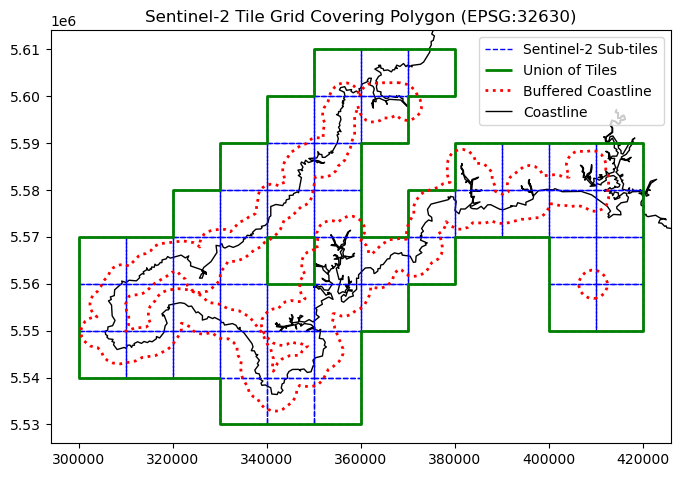

In [34]:
# Compute the union of all intersecting tiles
union_polygon = unary_union(tile_boxes)

# Convert to GeoDataFrame for plotting
gdf_tiles = gpd.GeoDataFrame(geometry=tile_boxes, crs="EPSG:32630")
gdf_union = gpd.GeoDataFrame(geometry=[union_polygon], crs="EPSG:32630")
gdf_polygon = gpd.GeoDataFrame(geometry=polygons_utm, crs="EPSG:32630")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_tiles.boundary.plot(ax=ax, color="blue", linewidth=1, linestyle="--", label="Sentinel-2 Sub-tiles")
gdf_union.boundary.plot(ax=ax, color="green", linewidth=2, label="Union of Tiles")
gdf_polygon.boundary.plot(ax=ax, color="red", linewidth=2, linestyle=":", label="Buffered Coastline")

# Plot land without changing axes
xlim, ylim = ax.get_xlim(), ax.get_ylim()
land_polys.boundary.plot(ax=ax, color="black", linewidth=1, zorder=1, label="Coastline")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels & Legend
ax.set_title("Sentinel-2 Tile Grid Covering Polygon (EPSG:32630)")
ax.legend()
plt.savefig(os.path.join(FIGURES_DIR, 's2_polygon_covering'))
plt.show()

In [35]:
tiles_4326 = gdf_tiles.to_crs("EPSG:4326")

In [36]:
tiles_wkt = [p.wkt for p in tiles_4326.geometry]

## Rectangle covering - all MGRS tiles

In [37]:
utm_year_fp = pd.read_csv(os.path.join(DATA_DIR, 'utm_years.csv'))

In [38]:
mgrs_tiles = utm_year_fp['utm_tile'].unique()

In [39]:
tiles_wkt_dict = dict()

In [ ]:
for tileId in mgrs_tiles:
    wkt_fp = os.path.join(DATA_DIR, f'coastline_buffer/Buffered_Coastline_{tileId}.wkt')
    if os.path.exists(wkt_fp):
        with open(wkt_fp, 'r') as f:
            wkt = f.read()
    poly = gpd.GeoSeries.from_wkt([wkt])
    
    tile_boxes, polygons_utm = create_epsg_grid(poly, land_polys)
    tiles_4326 = gpd.GeoDataFrame(geometry=tile_boxes, crs="EPSG:32630").to_crs("EPSG:4326")
    tiles_wkt = [p.wkt for p in tiles_4326.geometry]

    tiles_wkt_dict[tileId] = tiles_wkt

In [ ]:
import json

In [ ]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'w') as f:
    json.dump(tiles_wkt_dict, f)

In [43]:
with open(os.path.join(DATA_DIR, 'tile_buffer_wkt.json'), 'r') as f:
    tiles_wkt_dict = json.load(f)

In [44]:
tiles_wkt_dict

{'29UPB': ['POLYGON ((-7.404648411175394 55.236874968815165, -7.4145977624739094 55.32646881693898, -7.571710765230268 55.32067959884983, -7.561410270873474 55.23110493945405, -7.404648411175394 55.236874968815165))',
  'POLYGON ((-7.4145977624739094 55.32646881693898, -7.424602914491898 55.41606013911297, -7.582069009550961 55.41025164603064, -7.571710765230268 55.32067959884983, -7.4145977624739094 55.32646881693898))',
  'POLYGON ((-7.219356837482976 54.97359225850679, -7.228795515738707 55.06321191749716, -7.384915422576398 55.05767972573314, -7.37513095197927 54.96807834607767, -7.219356837482976 54.97359225850679))',
  'POLYGON ((-7.228795515738707 55.06321191749716, -7.238286828049059 55.152829155022026, -7.394754437472401 55.147278602515904, -7.384915422576398 55.05767972573314, -7.228795515738707 55.06321191749716))',
  'POLYGON ((-7.247831174604334 55.24244396410728, -7.2574289597299275 55.33205633770419, -7.4145977624739094 55.32646881693898, -7.404648411175394 55.2368749688

In [45]:
tiles_wkt = tiles_wkt_dict['30UUA']

In [46]:
gdf_tiles = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt(tiles_wkt), crs="EPSG:4326").to_crs("EPSG:32630")

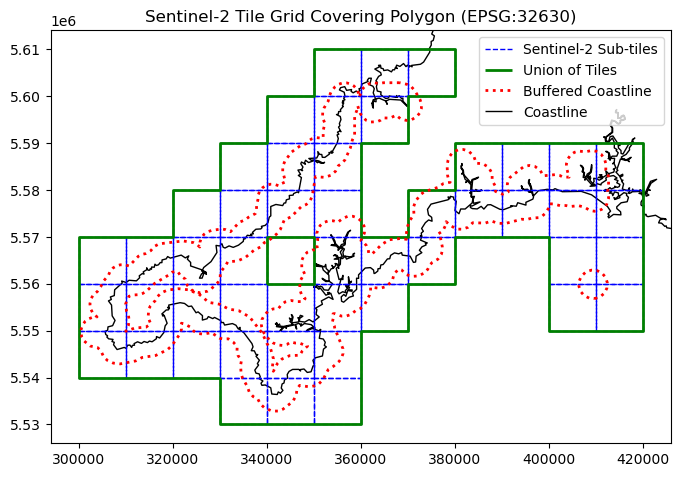

In [48]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_tiles.boundary.plot(ax=ax, color="blue", linewidth=1, linestyle="--", label="Sentinel-2 Sub-tiles")
gdf_union.boundary.plot(ax=ax, color="green", linewidth=2, label="Union of Tiles")
gdf_polygon.boundary.plot(ax=ax, color="red", linewidth=2, linestyle=":", label="Buffered Coastline")

# Plot land without changing axes
xlim, ylim = ax.get_xlim(), ax.get_ylim()
land_polys.boundary.plot(ax=ax, color="black", linewidth=1, zorder=1, label="Coastline")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels & Legend
ax.set_title("Sentinel-2 Tile Grid Covering Polygon (EPSG:32630)")
ax.legend()
plt.show()